In [1]:
%%capture hide_pip_output
!pip install pandas lxml geopandas matplotlib contextily pyproj

In [2]:
import ftplib
from io import BytesIO
import pandas as pd
from lxml import etree
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pyproj
from datetime import datetime

In [3]:
host="ftp.bom.gov.au"
path="/anon/gen/fwo"
file_name ="IDW60920.xml"
ftp = ftplib.FTP(host)
print(ftp.login("",""))
print(ftp.cwd(path))
xml_data = BytesIO()
print(ftp.retrbinary(f"RETR {file_name}",xml_data.write))
xml_data.seek(0)
xml_data = xml_data.read()

230 Login successful.
250 Directory successfully changed.
226 Transfer complete.


In [4]:
with open(file_name,"wb") as f:
    f.write(xml_data)

In [5]:
station_list = (
    pd.read_xml(
        xml_data,
        xpath="//station",
        dtype={'bom-id': 'str'}
    )
    .set_index('bom-id')
)

In [6]:
root = etree.fromstring(xml_data.decode("utf-8"))

bom_ids = []
columns_to_extract = ['wind_spd_kmh', 'wind_dir_deg', 'gust_kmh','air_temperature']
columns = {item:[] for item in columns_to_extract}

# Iterate over each station and extract data
for station in root.xpath('//station'):
    bom_id = station.get('bom-id')
    bom_ids.append(bom_id)
    for item in columns.keys():
        value = station.xpath('./period/level/element[@type="%s"]/text()' % item)
        columns[item].append(float(value[0]) if value else None)

# Construct DataFrame
wind_df = pd.DataFrame({
    'bom-id': bom_ids,
    **columns
}).set_index('bom-id')

In [7]:
merged_df =  station_list.join(wind_df)

# Convert lat and lon columns to floats
merged_df['lat'] = merged_df['lat'].astype(float)
merged_df['lon'] = merged_df['lon'].astype(float)
date_stamp = datetime.now().strftime('%Y-%m-%d')
merged_df.to_excel(f"{file_name.rsplit('.', maxsplit=1)[0]}-{date_stamp}.xlsx")
# Create a new geometry column from the lat and lon
geometry = [Point(xy) for xy in zip(merged_df['lon'], merged_df['lat'])]
geo_df = gpd.GeoDataFrame(merged_df, geometry=geometry)
geo_df

,wmo-id,tz,stn-name,stn-height,type,lat,lon,forecast-district-id,description,period,wind_spd_kmh,wind_dir_deg,gust_kmh,air_temperature,geometry
bom-id,,,,,,,,,,,,,,,
009225,94608,Australia/Perth,PERTH METRO,24.9,AWS,-31.9192,115.8728,WA_PW009,Perth,NaN,6.0,203.0,7.0,16.6,POINT (115.87280 -31.91920)
200735,94210,Australia/Perth,ADELE ISLAND,4.6,AWS,-15.5114,123.1556,WA_PW001,Adele Island,NaN,15.0,226.0,17.0,26.6,POINT (123.15560 -15.51140)
503621,99200,Australia/Perth,KOOLAN ISLAND (KOOLAN CENTRAL AIRPORT),163.2,AWS,-16.1242,123.7364,WA_PW001,Koolan Island / Koolan Central,NaN,13.0,353.0,15.0,24.9,POINT (123.73640 -16.12420)
009021,94610,Australia/Perth,PERTH AIRPORT,15.4,AWS,-31.9275,115.9764,WA_PW009,Perth Airport,NaN,15.0,187.0,17.0,16.7,POINT (115.97640 -31.92750)
009254,99254,Australia/Perth,ARMAMENT JETTY,9.0,AWS,-32.1758,115.6808,WA_PW009,Armament Jetty,NaN,7.0,3.0,7.0,NaN,POINT (115.68080 -32.17580)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250118,99458,Australia/Perth,DFES PORTABLE AWS C,20.0,AWS,-27.6868,114.2618,WA_FA001,PORTABLE BTSC (DFES),NaN,NaN,NaN,NaN,9.4,POINT (114.26180 -27.68680)
250119,99459,Australia/Perth,DFES PORTABLE AWS D,10.0,AWS,-31.2143,120.2593,WA_FA001,PORTABLE BTSD (DFES),NaN,NaN,NaN,NaN,6.6,POINT (120.25930 -31.21430)
250120,99460,Australia/Perth,DFES PORTABLE AWS E,10.0,AWS,-16.4203,126.4411,WA_FA001,PORTABLE BTSE (DFES),NaN,NaN,NaN,NaN,23.7,POINT (126.44110 -16.42030)


In [8]:
geo_df = geo_df.set_crs(epsg=4326)

In [9]:
#geo_df =  geo_df.to_crs(epsg=3857)

In [10]:
# Create a colormap based on the air_temperature values
cmap = matplotlib.colormaps['viridis']
norm = matplotlib.colors.Normalize(vmin=geo_df['air_temperature'].min(), vmax=geo_df['air_temperature'].max())
geo_df['color'] = [cmap(norm(value)) for value in geo_df['air_temperature']]


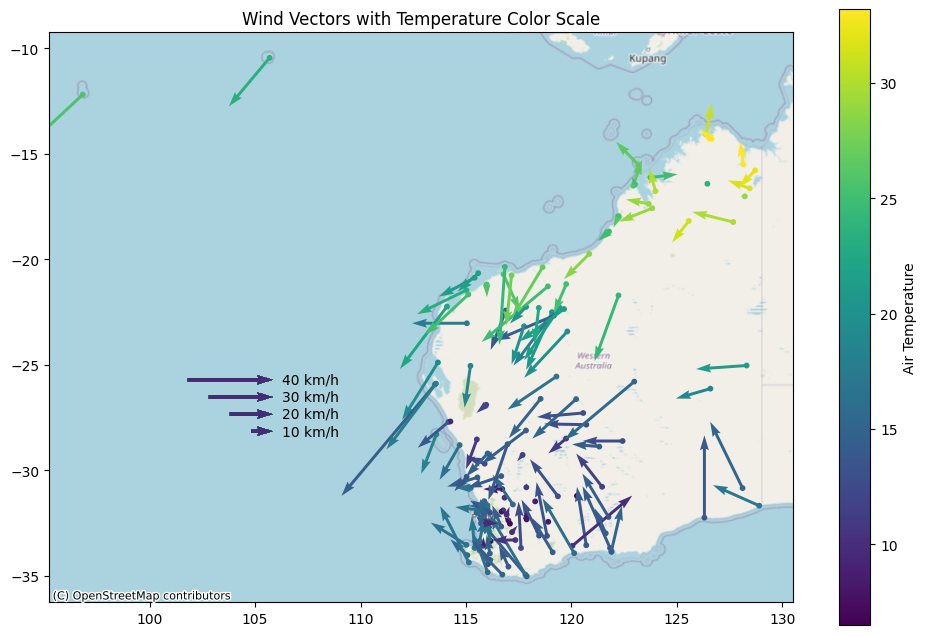

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

#ax.set_aspect('equal')
# ax.set_ylim(1.2, 1.4)
# ax.set_xlim(115.41, 116.5)

# Plot stations with colors based on air_temperature
geo_df.plot(ax=ax, color=geo_df['color'], markersize=10)

radians = np.deg2rad(360 - geo_df['wind_dir_deg'].astype(float))

# Plot vectors (arrows) with the same color as dots
quivers = ax.quiver(
    geo_df['geometry'].x,
    geo_df['geometry'].y,
    geo_df['wind_spd_kmh'].astype(float) * np.cos(radians),
    geo_df['wind_spd_kmh'].astype(float) * np.sin(radians),
    angles='xy',
    scale_units='xy',
    scale=10,
    color=geo_df['color'],
    width=0.004,
)

# key for quiver
for index, item in enumerate([10,20,30,40]):
    ax.quiverkey(
        quivers,
        X=0.3,
        Y=0.3+0.03*index,
        U=item,
        label=f'{item} km/h',
        labelpos='E',
        coordinates='axes'
    )
    

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Air Temperature')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zorder=-1, crs=geo_df.crs.to_string())
ax.set_title("Wind Vectors with Temperature Color Scale")
None